In [194]:
import sympy as sy
import numpy as np
import pandas as pd 
import math
from matplotlib import pyplot as plt

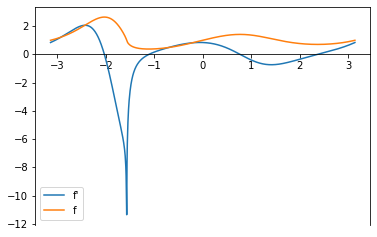

In [195]:
# Problem 1

# Define the function and take the derivative
x = sy.symbols('x')
f = (sy.sin(x) + 1) ** (sy.sin(sy.cos(x)))
f_prime = sy.diff(f)

# Lambdify the derivative function
f_lam = sy.lambdify(x, f, 'numpy')
f_prime_lam = sy.lambdify(x, f_prime, 'numpy')

# Plot the function graphs
x_coor = np.linspace(-np.pi, np.pi, 1000)
ax = plt.gca()
ax.spines['bottom'].set_position('zero')

plt.plot(x_coor, f_prime_lam(x_coor), label = 'f\'')
plt.plot(x_coor, f_lam(x_coor), label = 'f')
plt.legend()

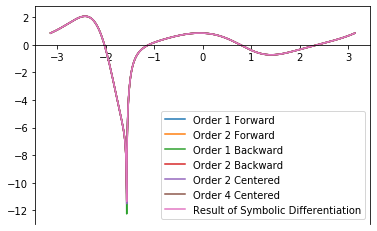

In [196]:
# Problem 2

# Define each of the finite difference quotients
def forward_1(f, x, h): 
    return (f(x+h) - f(x))/h


def forward_2(f, x, h): 
    return (-3 * f(x) + 4 * f(x+h) - f(x+2*h)) / (2 * h)


def backward_1(f, x, h): 
    return (f(x) - f(x-h))/h


def backward_2(f, x, h): 
    return (3 * f(x) - 4 * f(x-h) + f(x-2*h)) / (2 * h)


def centered_2(f, x, h): 
    return (f(x+h) - f(x-h)) / (2 * h)


def centered_4(f, x, h): 
    return (f(x-2*h) - 8 * f(x-h) + 8 * f(x+h) - f(x+2*h)) / (12 * h)


# Approximate the derivative of f on [-pi, pi] and plot the graph
ax = plt.gca()
ax.spines['bottom'].set_position('zero')

for quotient in [forward_1, forward_2, backward_1, backward_2, centered_2, centered_4]: 
    plt.plot(x_coor, [quotient(f_lam, x, 0.001) for x in x_coor], label=('Order ' + quotient.__name__.split('_')[1] + ' ' + quotient.__name__.split('_')[0].capitalize()))

# Plot the result of symbolic differentiation
plt.plot(x_coor, f_prime_lam(x_coor), label = "Result of Symbolic Differentiation")

plt.legend()

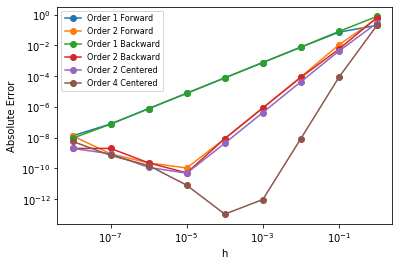

In [197]:
# Problem 3

# Define a function that returns the absolute value of the error
def error(x_0, h, formula):
    return abs(formula(f_lam, x_0, h) - f_prime_lam(x_0))


# Plot the errors for each trial on a log-log scale
x_coor_log = np.logspace(-8, 0, 9)

x_0 = 1 # Specify the value of x_0 here

for quotient in [forward_1, forward_2, backward_1, backward_2, centered_2, centered_4]: 
    plt.loglog(x_coor_log, [error(x_0, h, quotient) for h in x_coor_log], label=('Order ' + quotient.__name__.split('_')[1] + ' ' + quotient.__name__.split('_')[0].capitalize()), marker='o')

plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.legend(loc='upper left', prop = {'size': 8})


In [198]:
# Problem 4

# Load data from plane.npy and store it in a DataFrame
fhand = np.load('plane.npy')
data = pd.DataFrame(data=fhand, columns=['t', 'alpha', 'beta'])

# Define functions that calculate the coordinates
def x(alpha, beta): 
    return 500 * np.tan(np.deg2rad(beta)) / (np.tan(np.deg2rad(beta)) - np.tan(np.deg2rad(alpha)))

def y(alpha, beta): 
    return 500 * (np.tan(np.deg2rad(beta)) * np.tan(np.deg2rad(alpha))) / (np.tan(np.deg2rad(beta)) - np.tan(np.deg2rad(alpha)))

# Impute the coordinates and store into the DataFrame
data['x'] = x(data['alpha'], data['beta'])
data['y'] = y(data['alpha'], data['beta'])

# Define x(t) and y(t) and functions that approximate their derivatives

def x_t(t): 
    return float(data[data['t']==t]['x'])


def y_t(t): 
    return float(data[data['t']==t]['y'])


def x_prime(row): 
    if row['t'] == 7.0: 
        return forward_1(x_t, row['t'], 1)
    elif row['t'] == 14.0: 
        return backward_1(x_t, row['t'], 1)
    else: 
        return centered_2(x_t, row['t'], 1)


def y_prime(row): 
    if row['t'] == 7.0: 
        return forward_1(y_t, row['t'], 1)
    elif row['t'] == 14.0: 
        return backward_1(y_t, row['t'], 1)
    else: 
        return centered_2(y_t, row['t'], 1)


# Impute the approximated derivatives
data['x_prime'] = data.apply(x_prime, axis=1)
data['y_prime'] = data.apply(y_prime, axis=1)

# Calculate the speed
data['speed'] = ((data['x_prime'] ** 2) + (data['y_prime'] ** 2)) ** (1/2)

data[['t', 'speed']]

,t,speed
0,7.0,46.424201
1,8.0,47.001039
2,9.0,48.998805
3,10.0,50.099442
4,11.0,48.290351
5,12.0,51.564559
6,13.0,53.923034
7,14.0,51.514801


In [199]:
# Problem 5

def jacobian(f_list, x_0, h=0.001): 
    result = []
    for f in f_list: 
        jacobian_one_row = (f(*(x_0 + h * np.identity(len(x_0)))) - f(*(x_0 - h * np.identity(len(x_0))))) / (2 * h)
        result.append(jacobian_one_row)
    return np.array(result)

# Test the jacobian function
x, y = sy.symbols('x'), sy.symbols('y')

test_f_1 = x ** 2
test_f_2 = x ** 3 - y
test_f_1_lam = sy.lambdify((x, y), test_f_1)
test_f_2_lam = sy.lambdify((x, y), test_f_2)

f_list = [test_f_1_lam, test_f_2_lam]

jacobian(f_list, np.array([3, 5]))

array([[ 6.      ,  0.      ],
       [27.000001, -1.      ]])

In [200]:
# The result is same as that of SymPy. 

np.array([[sy.diff(test_f_1, x).subs({x: 3, y: 5}), sy.diff(test_f_1, y).subs({x: 3, y: 5})], 
         [sy.diff(test_f_2, x).subs({x: 3, y: 5}), sy.diff(test_f_2, y).subs({x: 3, y: 5})]])

array([[6, 0],
       [27, -1]], dtype=object)

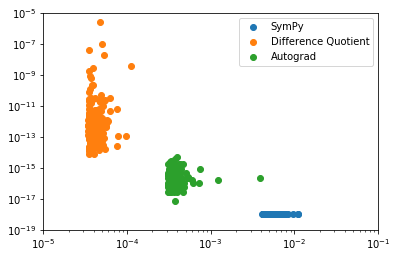

In [240]:
# Problem 6
from autograd import numpy as anp
from autograd import grad
from time import perf_counter

def experiment(N): 
    f_for_autograd = lambda x: (anp.sin(x) + 1) ** (anp.sin(anp.cos(x)))
    x_random_values = np.random.uniform(-np.pi, np.pi, N)
    time_sympy, time_difference, time_autograd = [], [], []
    error_sympy, error_difference, error_autograd = [], [], []
    for x_0 in x_random_values: 
        # time sympy
        time_start = perf_counter()
        f_prime_exact = sy.diff(f).subs({x: x_0})
        time_sympy.append(abs(perf_counter() - time_start))
        error_sympy.append(1e-18)
        # time difference quotient
        time_start = perf_counter()
        f_prime_difference = centered_4(f_lam, x_0, 0.001)
        time_difference.append(abs(perf_counter() - time_start))
        error_difference.append(abs(f_prime_exact - f_prime_difference))
        # time autograd
        time_start = perf_counter()
        f_prime_autograd = grad(f_for_autograd)(x_0)
        time_autograd.append(abs(perf_counter() - time_start))
        error_autograd.append(abs(f_prime_exact - f_prime_autograd))
    return {'time_sympy': time_sympy, 'time_difference': time_difference, 'time_autograd': time_autograd, 
            'error_sympy': error_sympy, 'error_difference': error_difference, 'error_autograd': error_autograd}
            
result = experiment(200)

plt.loglog()
plt.scatter(result['time_sympy'], result['error_sympy'], label='SymPy')
plt.scatter(result['time_difference'], result['error_difference'], label='Difference Quotient')
plt.scatter(result['time_autograd'], result['error_autograd'], label='Autograd')
plt.xlim(10 ** (-5), 10 ** (-1))
plt.ylim(10 ** (-19), 10 ** (-5))
plt.legend()